In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [47]:
(X, y), (_, _) = mnist.load_data()
X = X.reshape(-1, 28 * 28) / 255.0
print(X.shape)

(60000, 784)


In [48]:
def get_X_y(num_datapoints = 100):
  return X[:num_datapoints], y[:num_datapoints]


In [3]:
|def get_dists(X):
    """Return squared Euclidean pairwise distances."""

    n = X.shape[0]
    dists = np.zeros([n, n])

    for i in range(n):
        for j in range(i, n):
            dists[i, j] = np.sum((X[i, :] - X[j, :])**2)

    return dists + dists.T

In [4]:
def get_pij(d, scale, i):
    """
    Compute probabilities conditioned on point i from a row of distances
    d and a Gaussian scale (scale = 2*sigma^2).
    """

    d_scaled = -d/scale
    d_scaled -= np.max(d_scaled)
    exp_D = np.exp(d_scaled)
    exp_D[i] = 0

    return exp_D/np.sum(exp_D)


In [5]:
def get_entropy(p):
    """Calculates 2 ** H(p) of array p, where H(p) is the Shannon entropy."""
    return 2 ** np.sum(-p*np.log2(p+1e-10))

In [6]:
def get_P(D, target_perp = 30, LB = 0, UB = 1e4, tol = 1e-6, maxit = 250):
    """Optimize standard deviations to target perplexities with binary search.
    Returns joint probabilities."""

    n = D.shape[0]
    P = np.zeros(D.shape)

    for i in range(n):
        LB_i = LB
        UB_i = UB
        d = D[i, :]

        for t in range(maxit):
            # Find the perplexity using sigma = midpoint.
            midpoint = (LB_i + UB_i)/2
            scale = 2*midpoint**2
            p_ij = get_pij(d, scale, i)
            current_perp = get_entropy(p_ij)

            if current_perp < target_perp:
                LB_i = midpoint
            else:
                UB_i = midpoint

            if np.abs(current_perp-target_perp) < tol:
                break

        P[i,:] = p_ij

    return (P+P.T)/(2*n)

In [13]:
def get_Q(D, df=1):

    Q = np.power(1 + D/df, -1)
    np.fill_diagonal(Q, 0)
    return Q/np.sum(Q)

In [12]:
def get_grad(R, Y, D, df=1):
    """Compute the t-SNE gradient with raw Python."""

    n = Y.shape[0]
    dY = np.zeros(shape = Y.shape)

    Q = np.power(1 + D/df, -1)

    for i in range(n):
        for j in range(n):
            dY[i,:] += 4*R[i,j]*(Y[i, :] - Y[j, :])*Q[i, j]

    return dY

In [14]:
def constant(t, eta_init, last_eta, c = 100):
    """Constant learning rate."""
    return c

def tsne(X, niter = 1000, alpha_init = 0.5, alpha_final = 0.8, alpha_thr = 250,
         eta_init = 100, lr_fun = constant, d = 2, exg = 4, exg_thr = 50,
         perplexity = 30, pca_dims = 30, optim = "fastest", verbose = True, df = 1):
    """Run t-SNE.

    Required inputs:
        X - NxM matrix

    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        alpha_int - initial value of momentum
        alpha_final - final value of momentum term
        alpha_thr - iteration when momentum changes
        eta_init - initial learning rate
        lr_fun - learning rate function
        exg - multiplicative factor for early exaggeration
        exg_thr - iteration to stop exaggeration
        pca_dims - maximum number of dimensions before preprocessing with PCA
        optim - "none", "fast", or "fastest". Which level of optimization to run
        verbose - bool, whether or not to print a progress bar
        df - degrees of freedom of scaled t-distribution, df=1 is usual t-SNE

    Outputs:
        Y - (niter + 2) x N x d array of embeddings for each iteration"""

    # Get affinities with exaggeration.
    D = get_dists(X)
    pij = exg*get_P(D, perplexity)

    # Initialize first few iterations.
    size = (pij.shape[0], d)
    Y = np.zeros(shape = (niter + 2, size[0], d))
    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y[0, :, :] = Y_m1 = Y[1, :, :] = Y_m2 = initial_vals

    last_eta = eta_init
    alpha = alpha_init

    for i in range(2, niter + 2):

        print(f"Iteration {i-2}/{niter}")

        if i == int(alpha_thr):
            # Reduce momentum after some time.
            alpha = alpha_final

        if i == int(exg_thr):
            # Stop the exaggeration.
            pij /= exg

        # Compute gradient.
        Y_dists = get_Y_dists(Y_m1, df)
        qij = get_Q(Y_dists)
        rij = pij - qij
        grad = get_grad(rij, Y_dists, Y_m1)

        # # Update learning rate.
        # eta = lr_fun(i, eta_init, last_eta)
        # last_eta = eta
        eta = eta_init

        # Update embeddings.
        Y_new = Y_m1 - eta*grad + alpha*(Y_m1 - Y_m2)
        Y_m2, Y_m1 = Y_m1, Y_new
        Y[i, :, :] = Y_new

    return Y

In [31]:
def tsne_base(X, niter = 1000, eta = 100, d = 2, perplexity = 30):

    """Run t-SNE.

    Required inputs:
        X - NxM matrix

    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        eta - learning rate

    Outputs:
        Y - (niter) x N x d array of embeddings for each iteration"""

    D = get_dists(X)
    pij = get_P(D, perplexity)

    size = (pij.shape[0], d)
    Y_list = np.zeros(shape = (niter, size[0], d))

    Y = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y_list[0, :, :] = Y

    for i in range(0, niter):

        print(f"Iteration {i+1}/{niter}")

        # Compute gradient.
        D_ = get_dists(Y)
        qij = get_Q(D_)
        rij = pij - qij
        grad = get_grad(rij, Y, D_)

        # Update embeddings.
        Y_new = Y - eta*grad
        Y_list[i, :, :] = Y_new

        Y = Y_new

    return Y_list

In [32]:
def tsne_momentum(X, niter = 1000, eta = 100, d = 2, perplexity = 30,
                  alpha_init = 0.5, alpha_final = 0.8, alpha_thr = 250):

    """Run t-SNE.

    Required inputs:
        X - NxM matrix

    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        eta - learning rate
        alpha_int - initial value of momentum
        alpha_final - final value of momentum term
        alpha_thr - iteration when momentum changes

    Outputs:
        Y - (niter) x N x d array of embeddings for each iteration"""

    D = get_dists(X)
    pij = get_P(D, perplexity)

    size = (pij.shape[0], d)
    Y_list = np.zeros(shape = (niter + 2, size[0], d))

    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y_m1 = initial_vals
    Y_m2 = initial_vals

    Y_list[0, :, :] = Y_m1
    Y_list[1, :, :] = Y_m2

    alpha = alpha_init

    for i in range(2, niter + 2):

        print(f"Iteration {i-1}/{niter}")

        if i == int(alpha_thr):
            alpha = alpha_final

        # Compute gradient.
        D_ = get_dists(Y_m1)
        qij = get_Q(D_)
        rij = pij - qij
        grad = get_grad(rij, Y_m1, D_)

        # Update embeddings.
        Y_new = Y_m1 - eta*grad + alpha*(Y_m1 - Y_m2)
        Y_list[i, :, :] = Y_new

        Y_m2 = Y_m1
        Y_m1 = Y_new

    return Y_list

In [51]:
from sklearn.decomposition import PCA

def pca(X, k = 30):
    """Use PCA to project X to k dimensions."""

    # Center/scale the data.
    s = np.std(X, axis=0)
    s = np.where(s==0, 1, s)
    X = (X - np.mean(X, axis=0))/s

    # Run PCA with sklearn.
    pca_ = PCA(n_components=k)
    return pca_.fit_transform(X)

def tsne_pca(X, niter = 1000, eta = 100, d = 2, perplexity = 30,
                  alpha_init = 0.5, alpha_final = 0.8, alpha_thr = 250):

    """Run t-SNE.

    Required inputs:
        X - NxM matrix

    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        eta - learning rate
        alpha_int - initial value of momentum
        alpha_final - final value of momentum term
        alpha_thr - iteration when momentum changes

    Outputs:
        Y - (niter) x N x d array of embeddings for each iteration"""

    X = pca(X)

    D = get_dists(X)
    pij = get_P(D, perplexity)

    size = (pij.shape[0], d)
    Y_list = np.zeros(shape = (niter + 2, size[0], d))

    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y_m1 = initial_vals
    Y_m2 = initial_vals

    Y_list[0, :, :] = Y_m1
    Y_list[1, :, :] = Y_m2

    alpha = alpha_init

    for i in range(2, niter + 2):

        print(f"Iteration {i-1}/{niter}")

        if i == int(alpha_thr):
            alpha = alpha_final

        # Compute gradient.
        D_ = get_dists(Y_m1)
        qij = get_Q(D_)
        rij = pij - qij
        grad = get_grad(rij, Y_m1, D_)

        # Update embeddings.
        Y_new = Y_m1 - eta*grad + alpha*(Y_m1 - Y_m2)
        Y_list[i, :, :] = Y_new

        Y_m2 = Y_m1
        Y_m1 = Y_new

    return Y_list

In [33]:
def visualize_embedding(Y, labels):
    # Visualize the embedding
    plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='Spectral', s=1)
    plt.colorbar()
    plt.title('t-SNE embedding of the MNIST dataset')
    plt.show()

In [49]:
X, y = get_X_y(num_datapoints=1000)
print(X.shape)
print(y.shape)

(1000, 784)
(1000,)


Iteration 1/1000
Iteration 2/1000
Iteration 3/1000
Iteration 4/1000
Iteration 5/1000
Iteration 6/1000
Iteration 7/1000
Iteration 8/1000
Iteration 9/1000
Iteration 10/1000
Iteration 11/1000
Iteration 12/1000
Iteration 13/1000
Iteration 14/1000
Iteration 15/1000
Iteration 16/1000
Iteration 17/1000
Iteration 18/1000
Iteration 19/1000
Iteration 20/1000
Iteration 21/1000
Iteration 22/1000
Iteration 23/1000
Iteration 24/1000
Iteration 25/1000
Iteration 26/1000
Iteration 27/1000
Iteration 28/1000
Iteration 29/1000
Iteration 30/1000
Iteration 31/1000
Iteration 32/1000
Iteration 33/1000
Iteration 34/1000
Iteration 35/1000
Iteration 36/1000
Iteration 37/1000
Iteration 38/1000
Iteration 39/1000
Iteration 40/1000
Iteration 41/1000
Iteration 42/1000
Iteration 43/1000
Iteration 44/1000
Iteration 45/1000
Iteration 46/1000
Iteration 47/1000
Iteration 48/1000
Iteration 49/1000
Iteration 50/1000
Iteration 51/1000
Iteration 52/1000
Iteration 53/1000
Iteration 54/1000
Iteration 55/1000
Iteration 56/1000
I

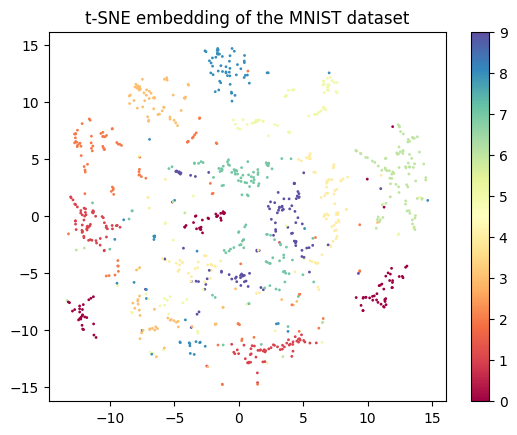

In [50]:
Y_list = tsne_base(X, niter=1000)
visualize_embedding(Y_list[-1], y)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


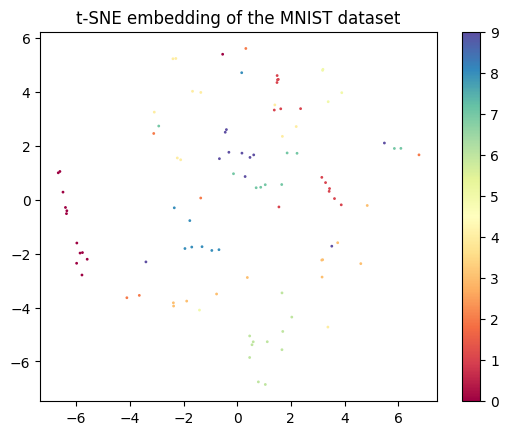

In [39]:
Y_list = tsne_momentum(X, niter=10, alpha_thr=5)
visualize_embedding(Y_list[-1], y)